In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC, SparseCategoricalAccuracy
import time
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import movmus as mm
import movmus2 as mm2

import json

## LOADING Model and EMG data

In [2]:
model_name = 'BASE_TASK_CONTEXT_MODEL_6'
model_folder = '.\\MODELS_TC'
plot_folder = '.\\PLOTS_TC'

In [6]:
model_name = 'BASE_SUBJ_CONTEXT_MODEL_4'
model_folder = '.\\MODELS_SC'
plot_folder = '.\\PLOTS_SC'

In [3]:
model = mm.load_model(model_folder, model_name)


Loading model from .\MODELS_TC\BASE_TASK_CONTEXT_MODEL_6.keras
Num Layers: 15
----
----
Layer: emg_input
{
    "batch_shape": [
        null,
        1000,
        7
    ],
    "dtype": "float32",
    "sparse": false,
    "name": "emg_input"
}
----
----
Layer: conv1d_34
{
    "name": "conv1d_34",
    "trainable": true,
    "dtype": {
        "module": "keras",
        "class_name": "DTypePolicy",
        "config": {
            "name": "float32"
        },
        "registered_name": null
    },
    "filters": 16,
    "kernel_size": [
        5
    ],
    "strides": [
        1
    ],
    "padding": "valid",
    "data_format": "channels_last",
    "dilation_rate": [
        1
    ],
    "groups": 1,
    "activation": "relu",
    "use_bias": true,
    "kernel_initializer": {
        "module": "keras.initializers",
        "class_name": "GlorotUniform",
        "config": {
            "seed": null
        },
        "registered_name": null
    },
    "bias_initializer": {
        "module"

In [4]:
train_data, val_data, test_data = mm.load_data_npz('EMG_1000_data.npz')

shape of training data: (2720, 1000, 7)
shape of validation data: (502, 1000, 7)
shape of test data: (661, 1000, 7)


In [5]:
train_labels, val_labels, test_labels = mm.load_data_npz('labels.npz')

shape of training data: (2720, 2)
shape of validation data: (502, 2)
shape of test data: (661, 2)


## task context data

In [6]:
validation_context_data = mm.load_metadata_npz('task_context_val.npz')
test_context_data = mm.load_metadata_npz('task_context_test.npz')
validation_context_data = validation_context_data.iloc[:, 1:]
test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape, validation_context_data.shape)

(661, 24) (502, 24)


## task context data (no shape)

In [7]:
validation_context_data = mm.load_metadata_npz('task_no_shape_context_val.npz')
test_context_data = mm.load_metadata_npz('task_no_shape_context_test.npz')
print(test_context_data.shape, validation_context_data.shape)

(661, 6) (502, 6)


## subject context data


In [10]:
validation_context_data = mm.load_metadata_npz('subject_context_val.npz')
validation_context_data = validation_context_data.iloc[:, 1:]
test_context_data = mm.load_metadata_npz('subject_context_test.npz')
test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape, validation_context_data.shape)

(661, 5) (502, 5)


## EVALUATION

In [7]:
test_context_data = test_context_data.to_numpy()

In [8]:
evaluation = model.evaluate([test_data, test_context_data], test_labels, verbose=0)
print(evaluation)

[0.10929939895868301, 0.9606656432151794, 0.9606656432151794, 0.9606656432151794, 0.9879704117774963]


In [9]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [10]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

y_pred_probs = model.predict([test_data, test_context_data])  
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.argmax(test_labels, axis=1)  
print(y_pred.shape, y_true.shape, test_labels.shape)
# Calcular métricas adicionales
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
print(f'Loss: {evaluation[0]}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

print(classification_report(y_true, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(661,) (661,) (661, 2)
Loss: 0.10929939895868301
Precision: 0.9733727810650887
Recall: 0.9508670520231214
Accuracy: 0.9606656580937972
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       315
           1       0.97      0.95      0.96       346

    accuracy                           0.96       661
   macro avg       0.96      0.96      0.96       661
weighted avg       0.96      0.96      0.96       661



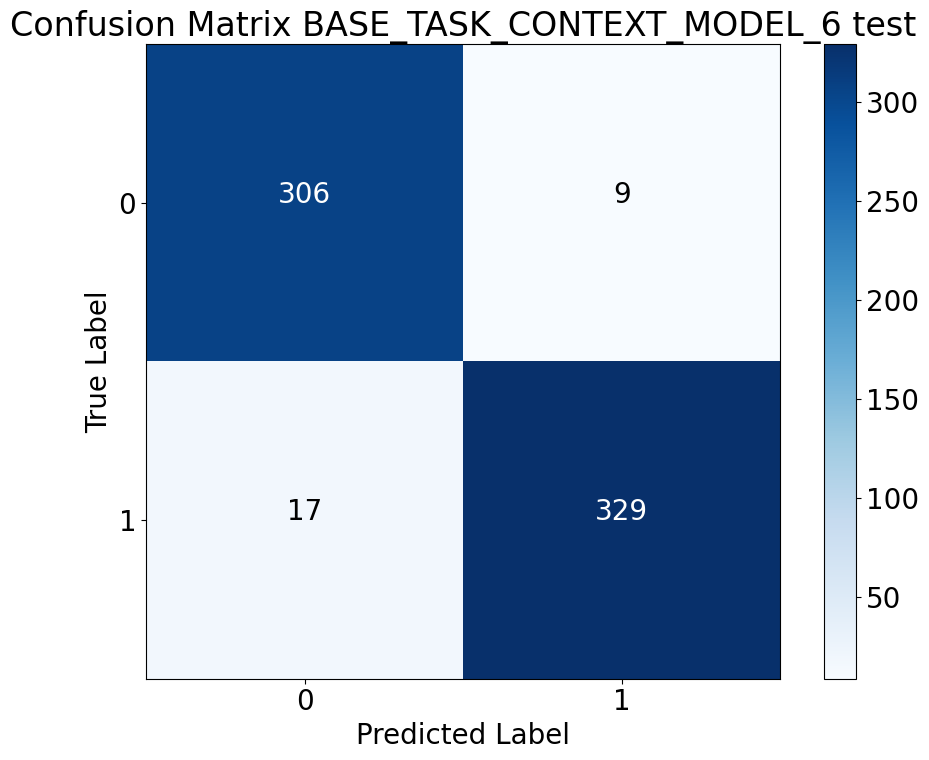

In [12]:
plt.rcParams.update({'font.size': 20})  # You can change the number to make it bigger/smaller

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix ' + model_name + ' test')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true)))  # this adapts to the number of classes dynamically
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Labeling the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig(f'{plot_folder}\\CM_{model_name}_test.png')

plt.show()


## LOSS STUDY (FOR TASK HYBRID MODELS)

### reload the context data depending on model

In [13]:
test_context_data = mm.load_metadata_npz('task_no_shape_test_id.npz')
print(test_context_data.shape)

(661, 7)


In [14]:
test_context_data = mm.load_metadata_npz('subject_context_test.npz')
test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape)

(661, 5)


In [15]:
test_context_data = mm.load_metadata_npz('task_context_test.npz')
#test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape)

(661, 25)


In [16]:
test_context_data.head(5)

,ID,WEIGHT,SPAN_1,SPAN_2,SHAPE_SPAN_1_1.0,SHAPE_SPAN_1_2.0,SHAPE_SPAN_1_3.0,SHAPE_SPAN_1_4.0,SHAPE_SPAN_1_5.0,SHAPE_SPAN_1_6.0,...,SHAPE_SPAN_2_7.0,SPAN_DH_1.0,SPAN_DH_2.0,ORI_PRODUCT_DH_1.0,ORI_PRODUCT_DH_2.0,ORI_PRODUCT_DH_3.0,ORI_PRODUCT_DH_4.0,TASK_HEIGHT_1.0,TASK_HEIGHT_2.0,TASK_HEIGHT_3.0
452,459.0,461.5,75.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
453,461.0,915.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
454,462.0,915.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
455,463.0,713.0,74.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
456,464.0,713.0,74.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### analysis of misclassifications

In [17]:
# Find indices of misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]

# Number of misclassified samples
num_misclassified = len(misclassified_indices)
print(f'Number of misclassified samples: {num_misclassified}')

Number of misclassified samples: 26


In [18]:
misclassified_metadata = test_context_data.iloc[misclassified_indices]
test_ids = mm.get_ids(test_context_data)
print(len(test_ids))
missclassified_ids = mm.get_ids(misclassified_metadata)
print(len(missclassified_ids))
print(missclassified_ids)

661
26
[756.0, 758.0, 759.0, 760.0, 761.0, 773.0, 775.0, 784.0, 942.0, 946.0, 961.0, 969.0, 971.0, 973.0, 1686.0, 1953.0, 1971.0, 2721.0, 2723.0, 2881.0, 2902.0, 3119.0, 3121.0, 3123.0, 3241.0, 3243.0]


In [19]:
df = pd.read_parquet('TFM_METADATA_FINAL.parquet')
print(df.shape)
metadata_test = mm.filter_by_ids(test_ids, df)
metadata_error_test = mm.filter_by_ids(missclassified_ids, df)
print(metadata_test.shape, metadata_error_test.shape)

(3883, 23)
(661, 23) (26, 23)


#### grouping by task and et (and task context)

In [61]:
error_test_task_et = metadata_error_test.groupby(['T', 'ET']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)

metadata_test_task_et = metadata_test.groupby(['T', 'ET']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=True)

In [62]:
error_test_task_et

,T,ET,count,ids
0,116.0,85.0,4,"[756.0, 942.0, 1686.0, 1953.0]"
13,207.0,376.0,4,"[2721.0, 2881.0, 3121.0, 3241.0]"
14,208.0,382.0,3,"[2723.0, 3123.0, 3243.0]"
3,118.0,97.0,2,"[760.0, 946.0]"
7,132.0,155.0,2,"[775.0, 961.0]"
1,117.0,91.0,1,[758.0]
2,117.0,94.0,1,[759.0]
4,118.0,100.0,1,[761.0]
5,130.0,147.0,1,[773.0]
6,131.0,151.0,1,[1971.0]


In [65]:
error_test_task_et.head(10).sort_values(by='T', ascending=True)

,T,ET,count,ids
0,116.0,85.0,4,"[756.0, 942.0, 1686.0, 1953.0]"
1,117.0,91.0,1,[758.0]
2,117.0,94.0,1,[759.0]
3,118.0,97.0,2,"[760.0, 946.0]"
4,118.0,100.0,1,[761.0]
5,130.0,147.0,1,[773.0]
6,131.0,151.0,1,[1971.0]
7,132.0,155.0,2,"[775.0, 961.0]"
13,207.0,376.0,4,"[2721.0, 2881.0, 3121.0, 3241.0]"
14,208.0,382.0,3,"[2723.0, 3123.0, 3243.0]"


In [66]:
metadata_test_task_et = metadata_test_task_et[metadata_test_task_et['T'].isin(error_test_task_et['T'])]
metadata_test_task_et = metadata_test_task_et[metadata_test_task_et['ET'].isin(error_test_task_et['ET'])]
metadata_test_task_et

,T,ET,count,ids
114,227.0,453.0,2,"[2742.0, 2902.0]"
101,206.0,370.0,5,"[2599.0, 2719.0, 2799.0, 2879.0, 3119.0]"
28,116.0,85.0,5,"[756.0, 942.0, 1128.0, 1686.0, 1953.0]"
59,144.0,194.0,6,"[508.0, 787.0, 973.0, 1159.0, 1717.0, 1984.0]"
45,130.0,147.0,6,"[494.0, 773.0, 959.0, 1145.0, 1703.0, 1970.0]"
33,118.0,100.0,6,"[482.0, 761.0, 947.0, 1133.0, 1691.0, 1958.0]"
31,117.0,94.0,6,"[480.0, 759.0, 945.0, 1131.0, 1689.0, 1956.0]"
30,117.0,91.0,6,"[479.0, 758.0, 944.0, 1130.0, 1688.0, 1955.0]"
46,131.0,151.0,6,"[495.0, 774.0, 960.0, 1146.0, 1704.0, 1971.0]"
32,118.0,97.0,6,"[481.0, 760.0, 946.0, 1132.0, 1690.0, 1957.0]"


In [22]:
print(metadata_test_task_et[(metadata_test_task_et['T'] == 116.0) & (metadata_test_task_et['ET'] == 85.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 207.0) & (metadata_test_task_et['ET'] == 376.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 208.0) & (metadata_test_task_et['ET'] == 382.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 118.0) & (metadata_test_task_et['ET'] == 97.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 132.0) & (metadata_test_task_et['ET'] == 155.0)])


        T    ET  count                                     ids
28  116.0  85.0      5  [756.0, 942.0, 1128.0, 1686.0, 1953.0]
         T     ET  count                                               ids
103  207.0  376.0      6  [2601.0, 2721.0, 2801.0, 2881.0, 3121.0, 3241.0]
         T     ET  count                                               ids
105  208.0  382.0      6  [2603.0, 2723.0, 2803.0, 2883.0, 3123.0, 3243.0]
        T    ET  count                                            ids
32  118.0  97.0      6  [481.0, 760.0, 946.0, 1132.0, 1690.0, 1957.0]
        T     ET  count                                            ids
47  132.0  155.0      6  [496.0, 775.0, 961.0, 1147.0, 1705.0, 1972.0]


of the 5 cases in all of the test data with this specific T and ET combination,4 were misclassified 

#### grouping by participant

In [30]:
error_participant = metadata_error_test.groupby(['PARTICIPANT', 'GENDER']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)
error_participant

,PARTICIPANT,GENDER,count,ids
0,9.0,1.0,10,"[756.0, 758.0, 759.0, 760.0, 761.0, 773.0, 775..."
1,11.0,0.0,6,"[942.0, 946.0, 961.0, 969.0, 971.0, 973.0]"
2,19.0,1.0,4,"[1686.0, 3119.0, 3121.0, 3123.0]"
3,22.0,0.0,2,"[1953.0, 1971.0]"
4,29.0,1.0,2,"[2881.0, 2902.0]"
5,30.0,0.0,2,"[3241.0, 3243.0]"


In [42]:
metadata_participant = metadata_test.groupby(['PARTICIPANT', 'GENDER']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)
metadata_participant = metadata_participant[metadata_participant['PARTICIPANT'].isin(error_participant['PARTICIPANT'])]
metadata_participant

,PARTICIPANT,GENDER,count,ids
4,19.0,1.0,112,"[1658.0, 1659.0, 1660.0, 1661.0, 1662.0, 1663...."
1,9.0,1.0,111,"[728.0, 729.0, 730.0, 731.0, 732.0, 733.0, 734..."
2,11.0,0.0,92,"[914.0, 915.0, 916.0, 917.0, 918.0, 919.0, 920..."
5,22.0,0.0,83,"[1933.0, 1935.0, 1936.0, 1938.0, 1939.0, 1940...."
9,30.0,0.0,23,"[3231.0, 3233.0, 3235.0, 3237.0, 3241.0, 3243...."
8,29.0,1.0,20,"[2871.0, 2873.0, 2875.0, 2877.0, 2879.0, 2881...."


#### grouping by product

In [69]:
error_product = metadata_error_test.groupby(['PRODUCT_DH']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='PRODUCT_DH', ascending=True)
error_product

,PRODUCT_DH,count,ids
0,13.0,6,"[756.0, 773.0, 942.0, 1686.0, 1953.0, 3119.0]"
1,14.0,7,"[758.0, 759.0, 1971.0, 2721.0, 2881.0, 3121.0,..."
2,15.0,8,"[760.0, 761.0, 775.0, 946.0, 961.0, 2723.0, 31..."
3,20.0,1,[969.0]
4,21.0,2,"[784.0, 2902.0]"
5,22.0,1,[971.0]
6,24.0,1,[973.0]


In [75]:
metadata_product = metadata_test.groupby(['PRODUCT_DH']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)
metadata_product = metadata_product[metadata_product['PRODUCT_DH'].isin(error_product['PRODUCT_DH'])]
metadata_product = metadata_product.sort_values(by='PRODUCT_DH', ascending=True)
metadata_product

,PRODUCT_DH,count,ids
12,13.0,24,"[494.0, 756.0, 757.0, 773.0, 942.0, 943.0, 959..."
13,14.0,25,"[479.0, 480.0, 495.0, 758.0, 759.0, 774.0, 944..."
14,15.0,26,"[481.0, 482.0, 496.0, 760.0, 761.0, 775.0, 946..."
19,20.0,6,"[504.0, 783.0, 969.0, 1155.0, 1713.0, 1980.0]"
20,21.0,9,"[505.0, 784.0, 970.0, 1156.0, 1714.0, 1981.0, ..."
21,22.0,6,"[506.0, 785.0, 971.0, 1157.0, 1715.0, 1982.0]"
23,24.0,6,"[508.0, 787.0, 973.0, 1159.0, 1717.0, 1984.0]"


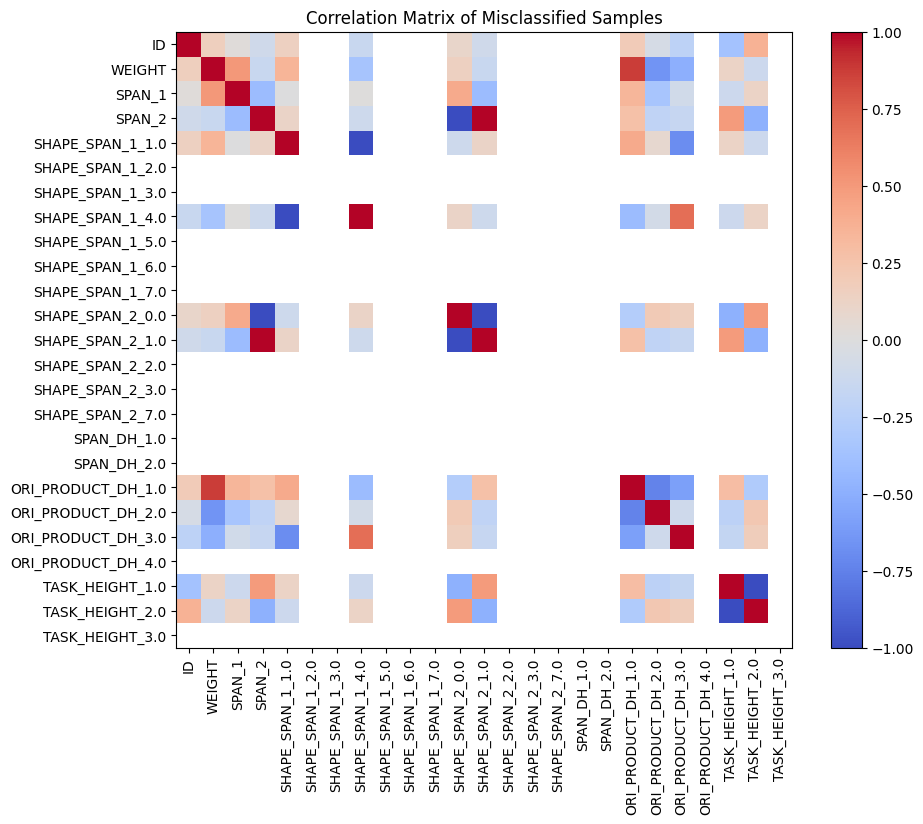

In [34]:
import numpy as np

# Compute the correlation matrix for misclassified samples
corr_matrix = misclassified_metadata.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# Add labels
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Add title
plt.title('Correlation Matrix of Misclassified Samples')

# Show plot
plt.show()

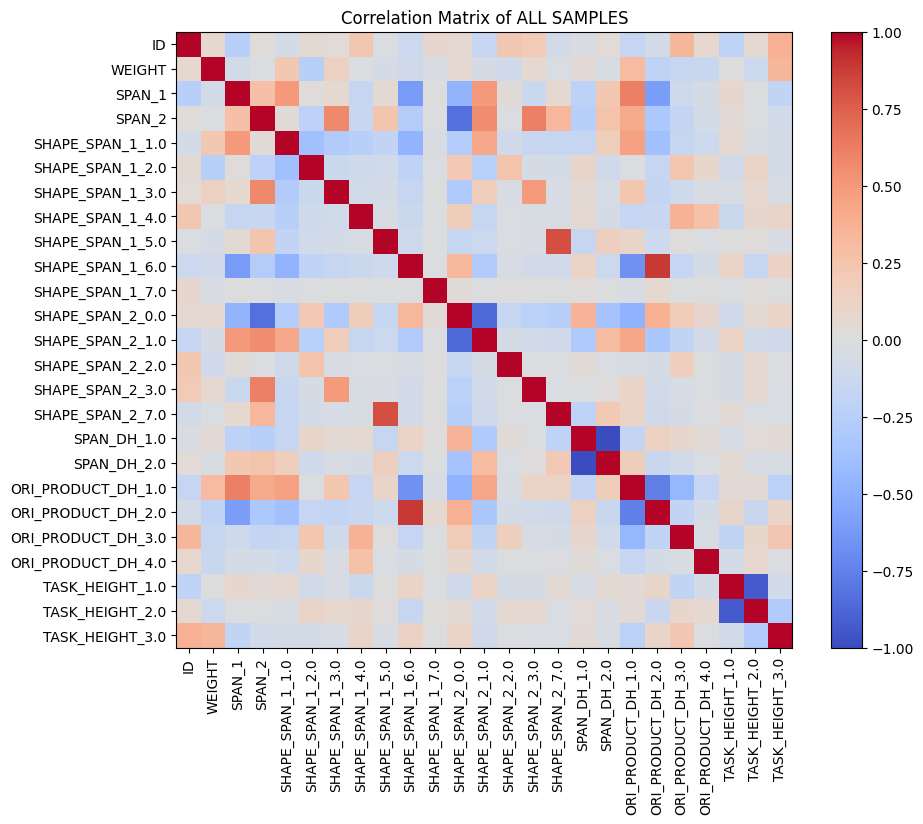

In [35]:
import numpy as np

# Compute the correlation matrix for misclassified samples
corr_matrix = test_context_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# Add labels
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Add title
plt.title('Correlation Matrix of ALL SAMPLES')

# Show plot
plt.show()

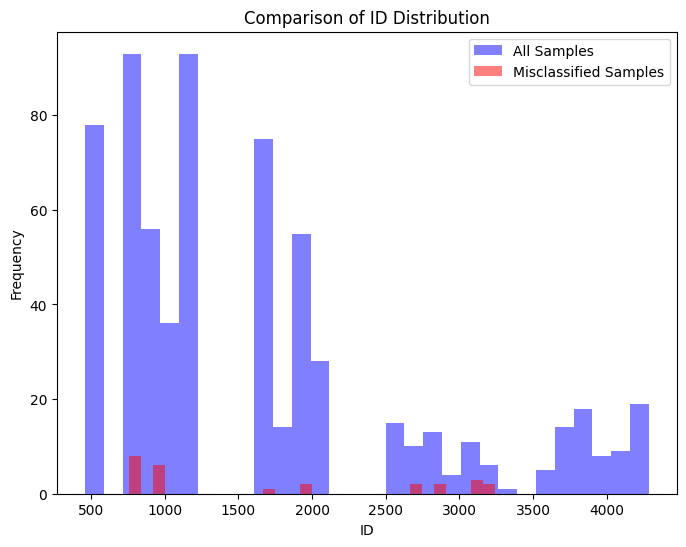

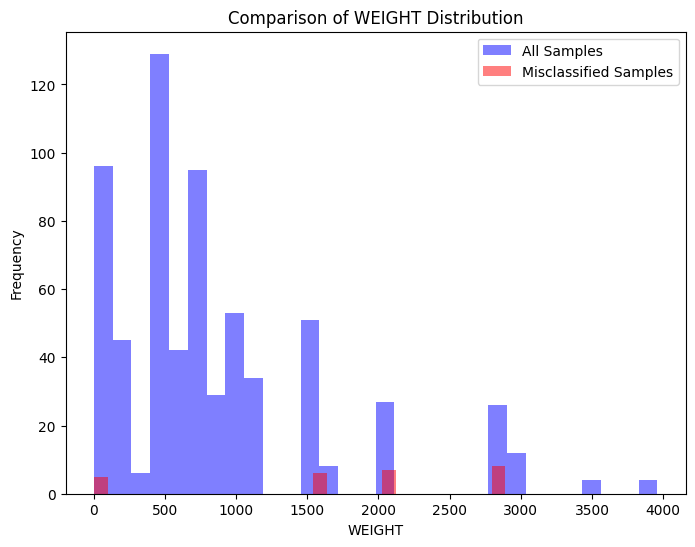

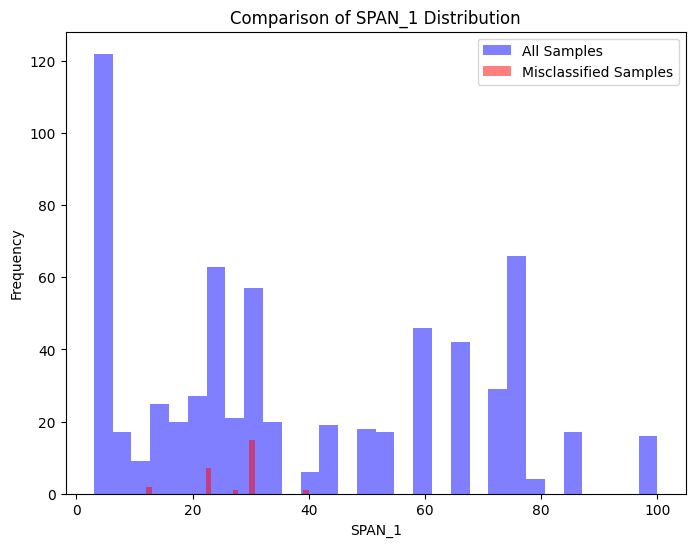

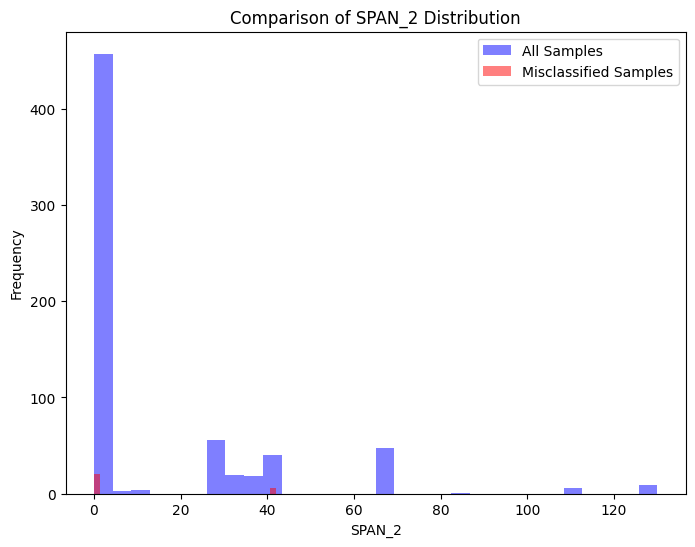

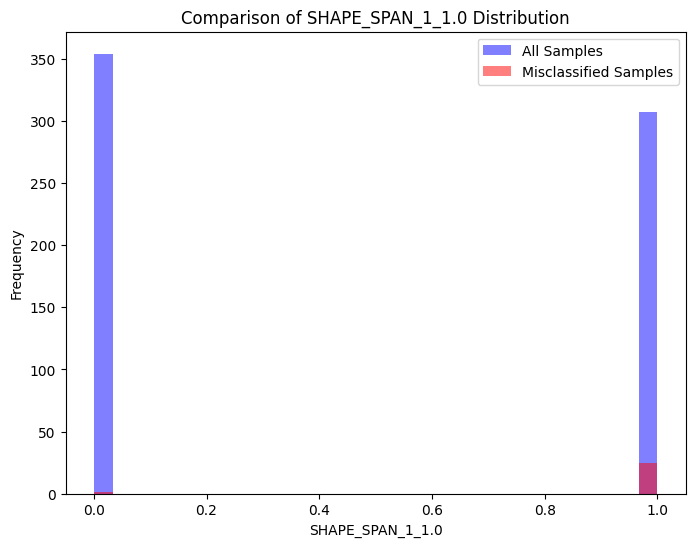

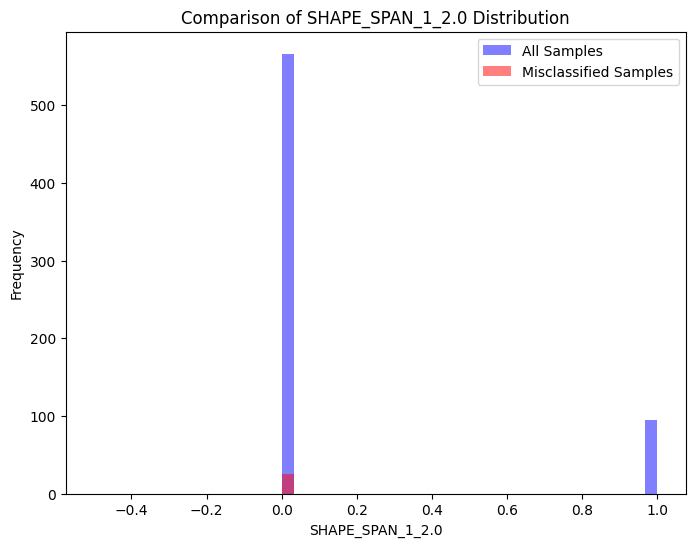

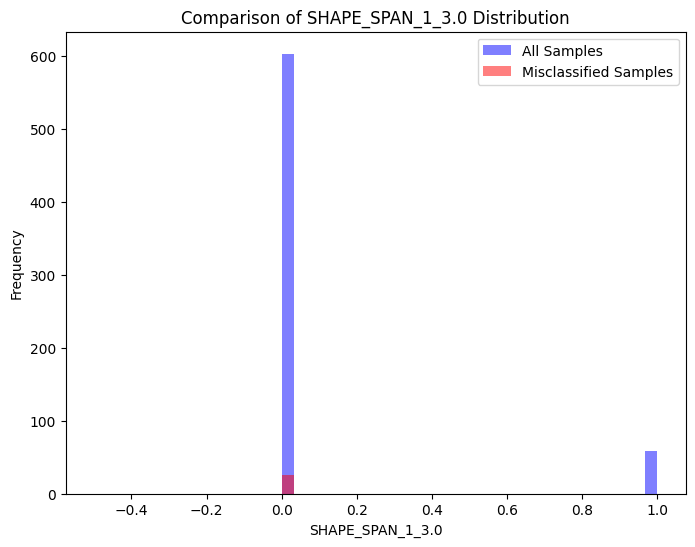

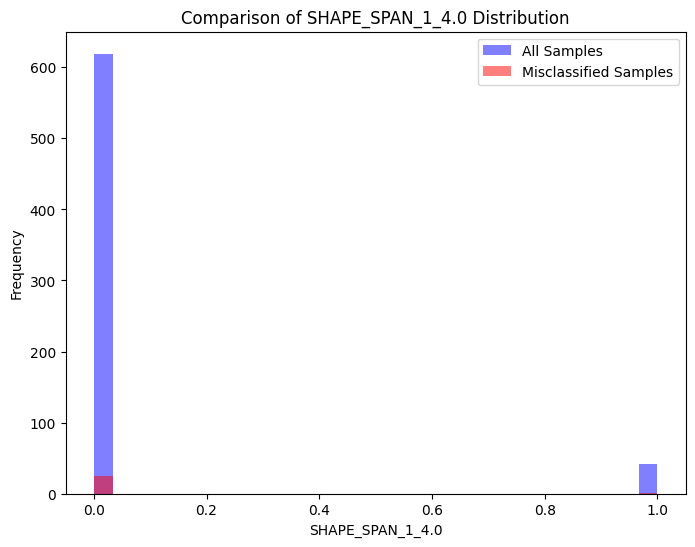

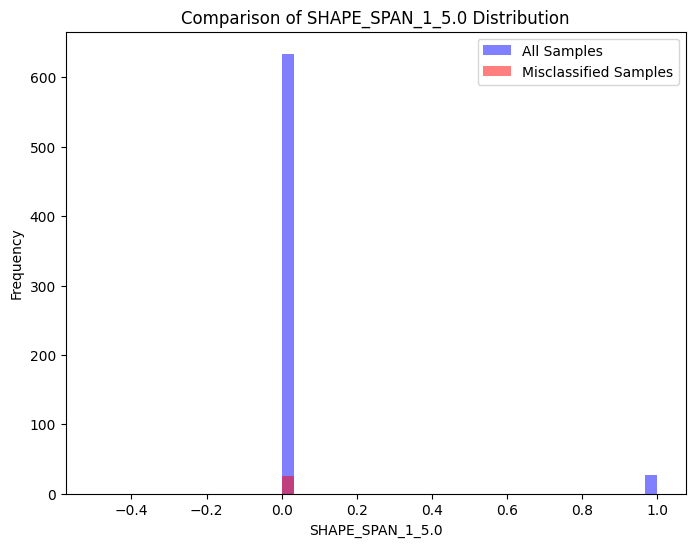

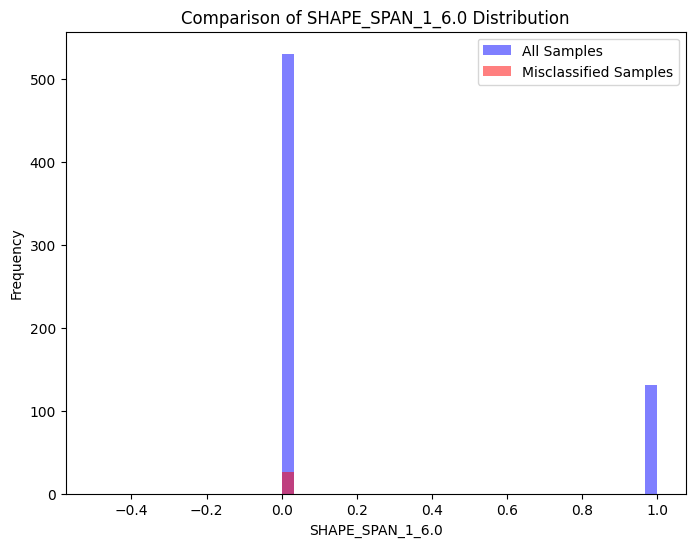

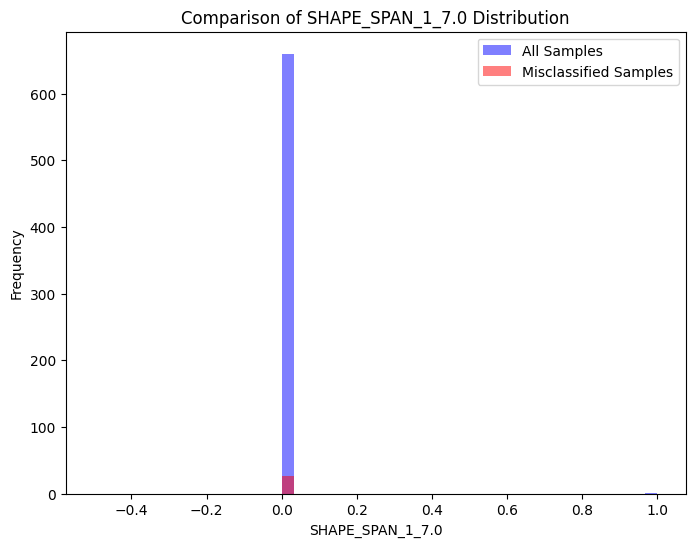

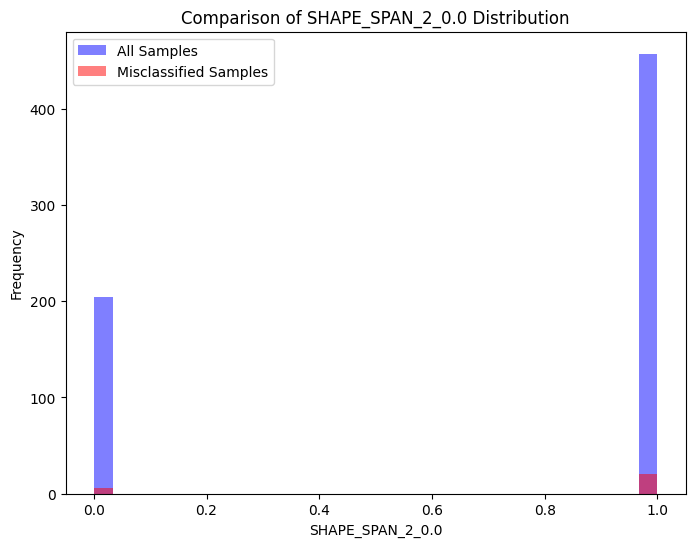

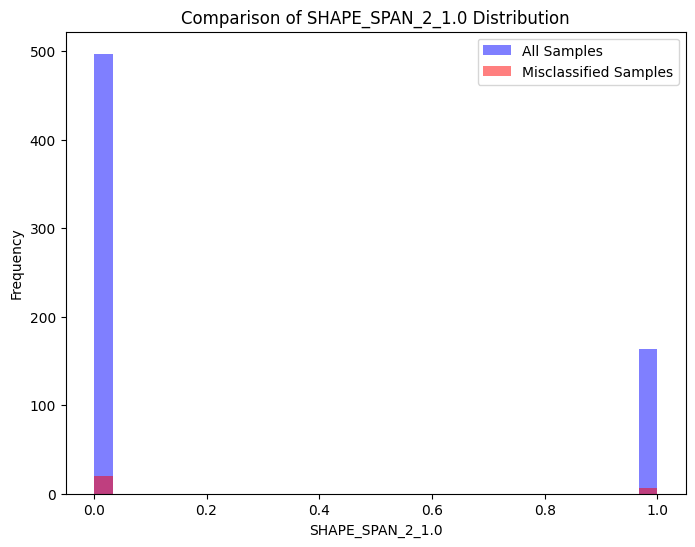

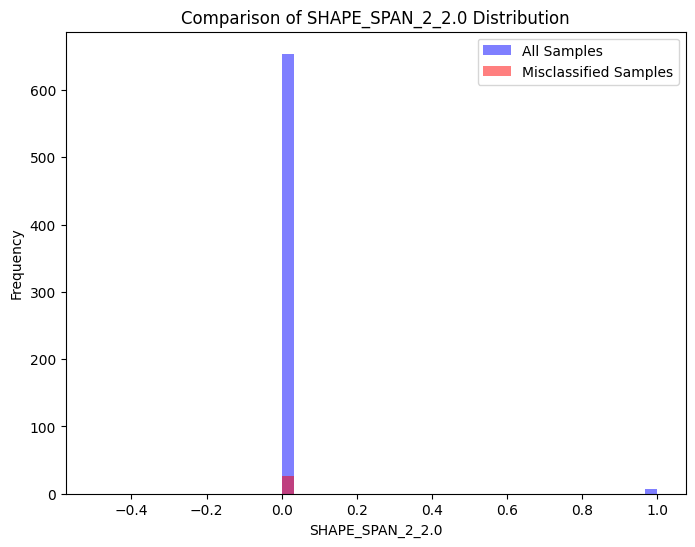

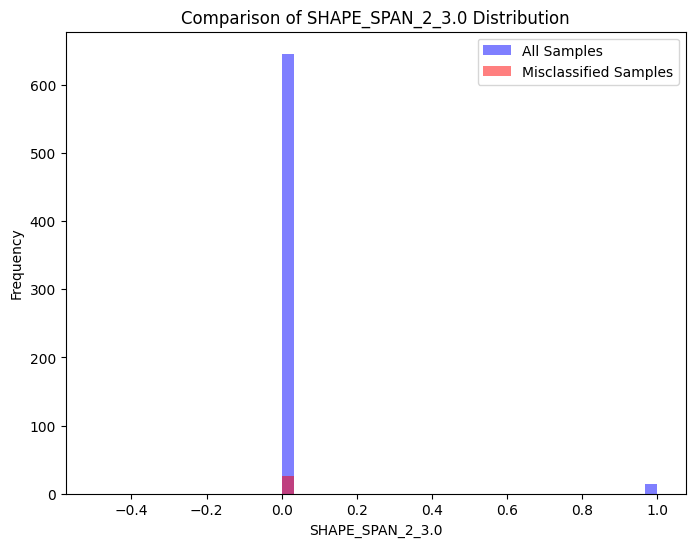

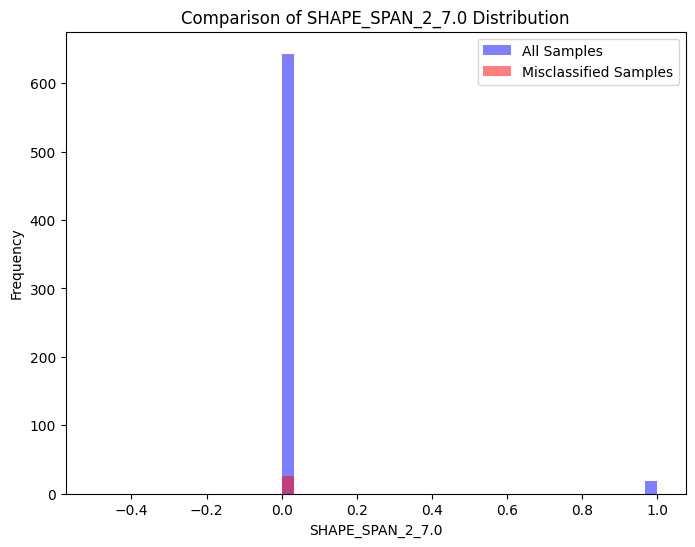

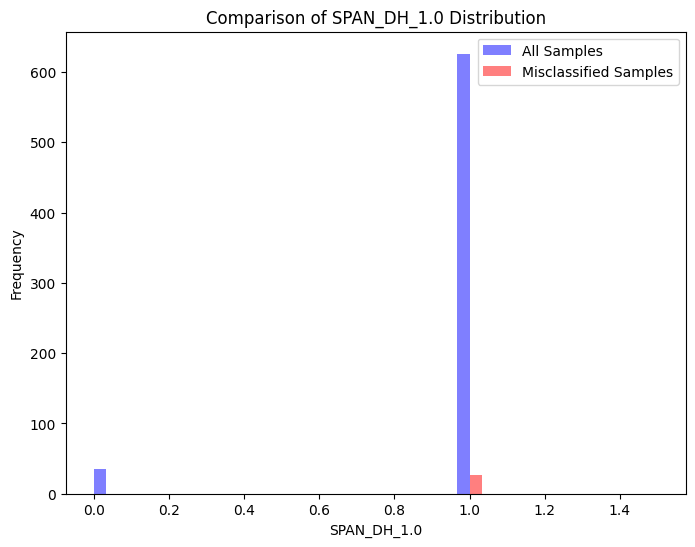

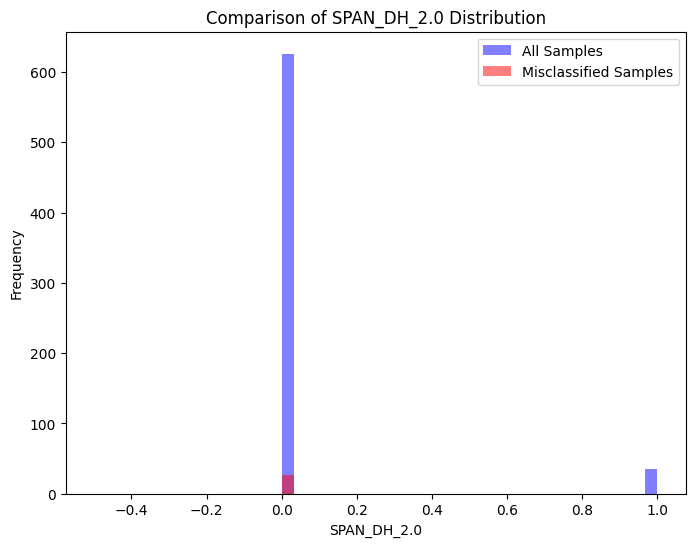

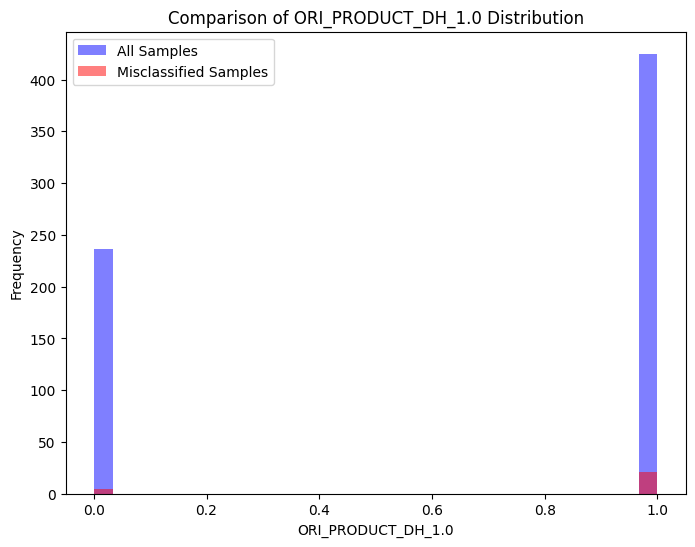

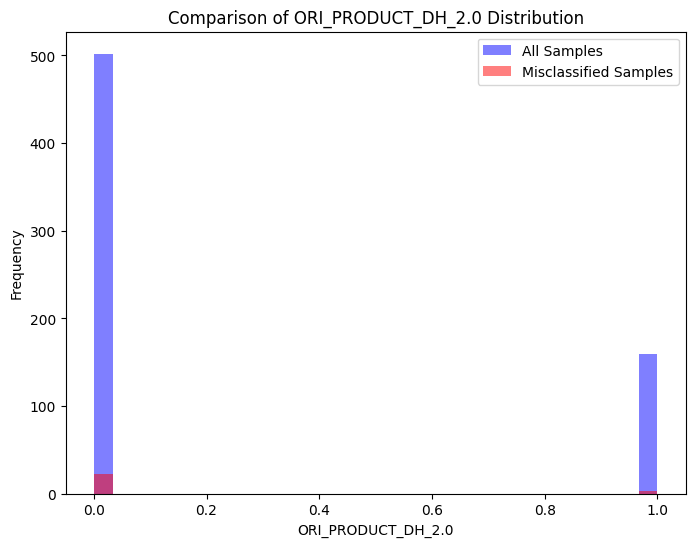

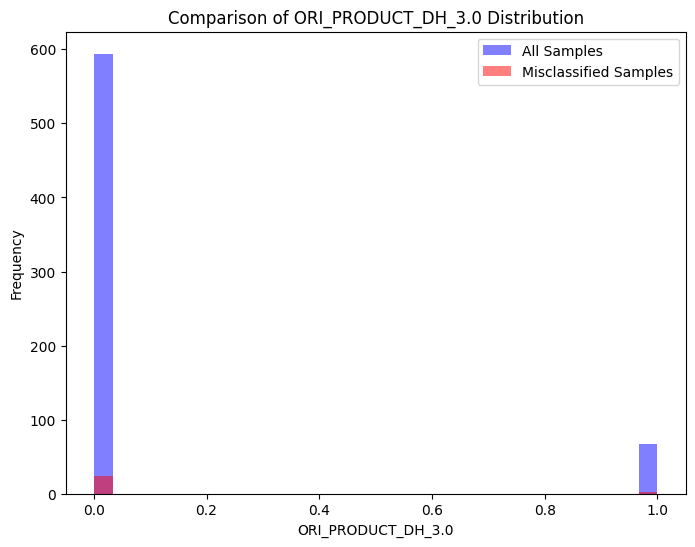

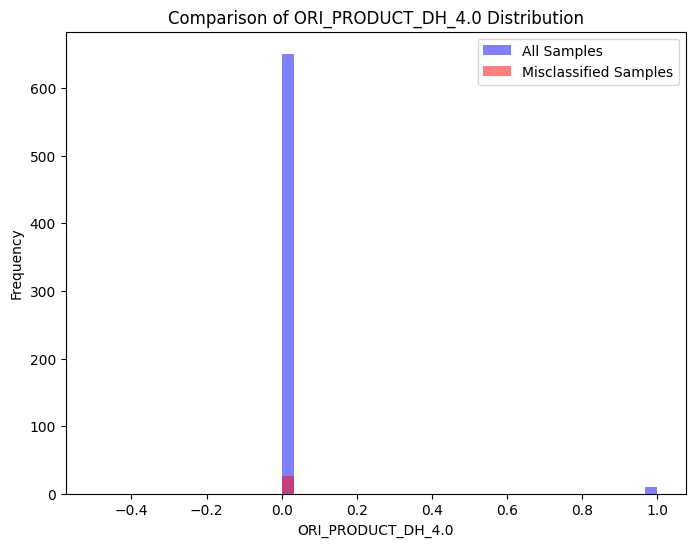

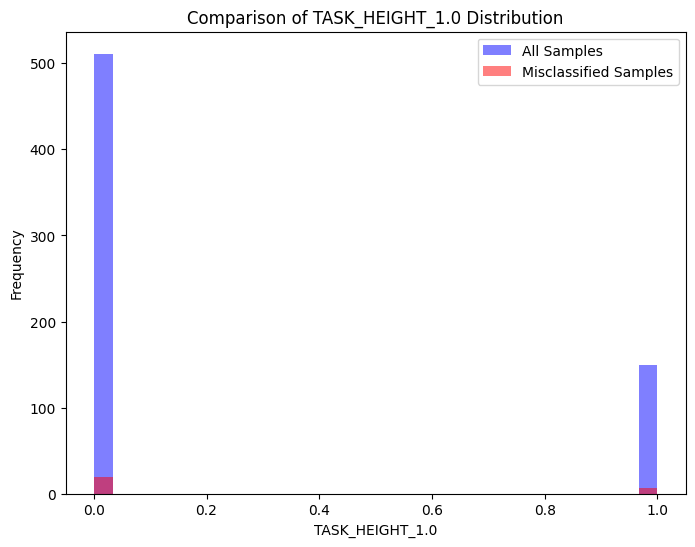

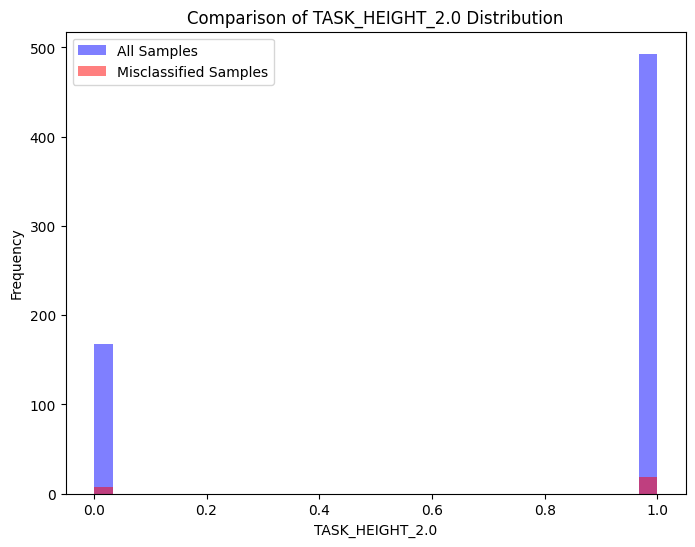

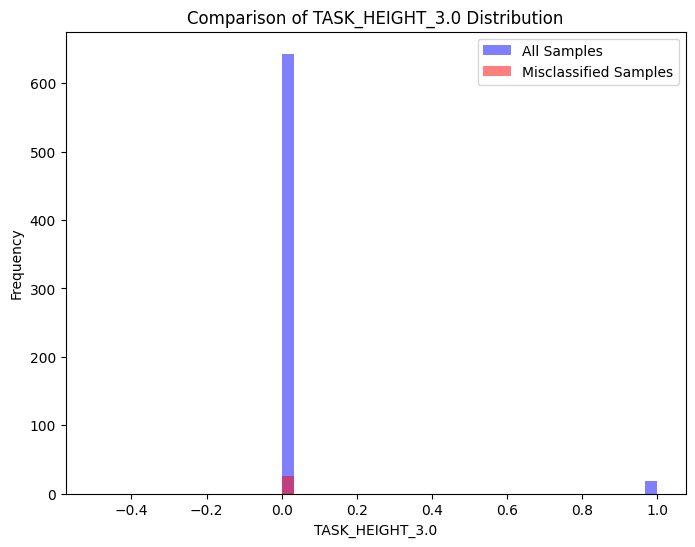

In [36]:
for feature in test_context_data.columns:
    plt.figure(figsize=(8, 6))
    
    # Histogram for all samples
    plt.hist(test_context_data[feature], bins=30, color='blue', alpha=0.5, label='All Samples')
    
    # Histogram for misclassified samples
    plt.hist(misclassified_metadata[feature], bins=30, color='red', alpha=0.5, label='Misclassified Samples')
    
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {feature} Distribution')
    plt.legend()
    plt.show()